# Knowledge Survival Model
## Lindy Effect / Pareto Model
- $S(t)=qS_\text{Lindy}(t)+(1-q)S_\text{Jump}(t)$
  - Jump handles "big-bang" epistemic resets.
  - $S_\text{Jump}$ seems like the emergence of a competing truth.
  - Draw the *life-length* $\tau$ from this mixture $S(t)$ once, at $t=0$
    - $I_t=
          \begin{cases}
              1, t<\tau\\
              0, t\ge\tau
          \end {cases}$
  - $S(t)$ measures two thresholds:
    - **Truth collapse threshold** $\theta_\text{truth}$ (e.g., $T_t \le 0.1$)
    - **Utility collapse threshold** $\theta_\text{util}$ (e.g., $U_t \le 0.05 \times U_0$)
    - $\tau$ is the first hitting time of either threshold or an exogenous paradigm-shifting event.
      - The empirical $S(t)$ then becomes the survival curve of "value above minimal relevance."
      - In practice:
        - Simulate $T_t$ and $U_t$
        - Set $\tau = \text{inf}\{t:T_t\le\theta_\text{truth} \text{ or } U_t\le\theta_\text{util}\}$
    - Estimate $S(t)$ non-parametrically from historical citation-decay data and then blend Lindy tails for the far relevance horizon.

In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)  # `None` means displaying all rows
pd.set_option('display.max_columns', None)

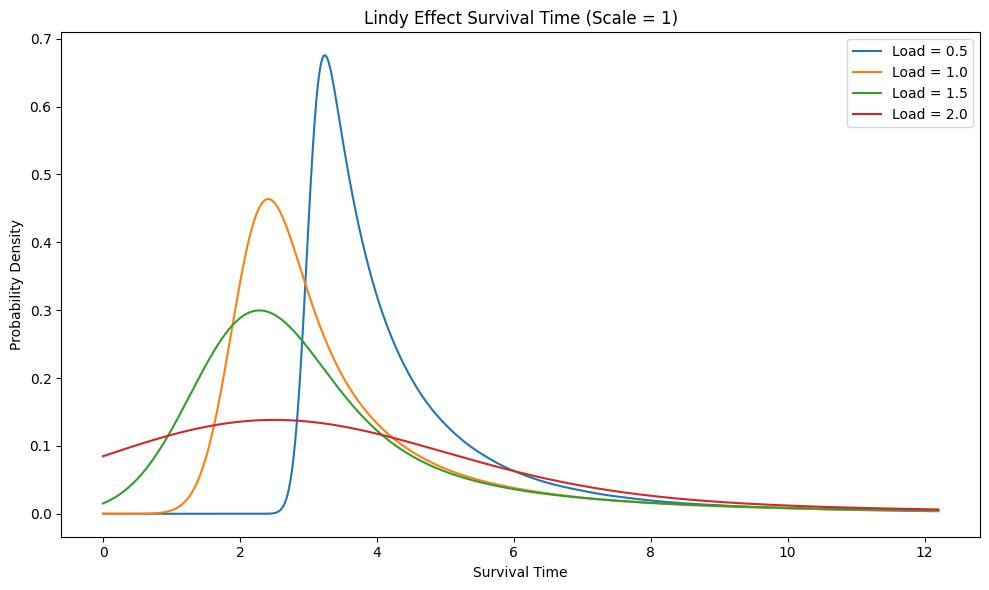

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pareto


# Generate Lindy Effect Survival data
def generate_lindy_effect_data(n_sims=10_000, load=1, scale=1):
    scale = (1+load)/load

    # Generate Pareto-distributed data
    data = pareto.rvs(scale, size=n_sims, scale=scale)
    
    # # Create a DataFrame to hold the data
    # df = pd.DataFrame(data, columns=['Survival Time'])
    
    # # Calculate the Lindy Effect (logarithm of survival time)
    # df['Lindy Effect'] = np.log(df['Survival Time'])
    
    return data

n_sims = 100_0000

# Simulate Linde Effect
truth_param_list = [0.5, 1.0, 1.5, 2.0]
lindy_sims = [generate_lindy_effect_data(n_sims=n_sims, load=load) for load in truth_param_list]
density_list = [stats.gaussian_kde(sim) for sim in lindy_sims]

# Plot the Lindy Effect Survival data
plt.figure(figsize=(10, 6))
x = np.linspace(0, max([np.percentile(sim, 95) * 1.1 for sim in lindy_sims]), 1000)
for idx, load in enumerate(truth_param_list):
    plt.plot(x, density_list[idx](x), label=f'Load = {load}')
plt.legend(loc='best')
plt.title('Lindy Effect Survival Time (Scale = 1)')
plt.xlabel('Survival Time')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()


## Modeling Decay/Distortion
- "Deterioration + shock" framework
- Components:
  - Erosion (slow blur of knowledge)
    - Erosion $D_t$ is Gamma with mean drift $\alpha t$
  - Recovery (restoration)
  - Shocks (misinformation events)
    - Compound Negative Binomial $\sum_{i=1}^{N_t}Z_i$ where $Z_i \sim \text{Lognormal/Pareto}$
- Truth level $T_t \sim e^{-D_t+\text{Recovery}_t-J_t}$ clipped at $[0, 1]$.
  - $J_t=\sum_i^{N_t} Z_i$ where $N_t\sim \text{Poisson}(\lambda_t)$ representing misinformation shocks.
    - $N_t$ will be modeled as discrete annual shocks

### Monthly Truth Level Simulation

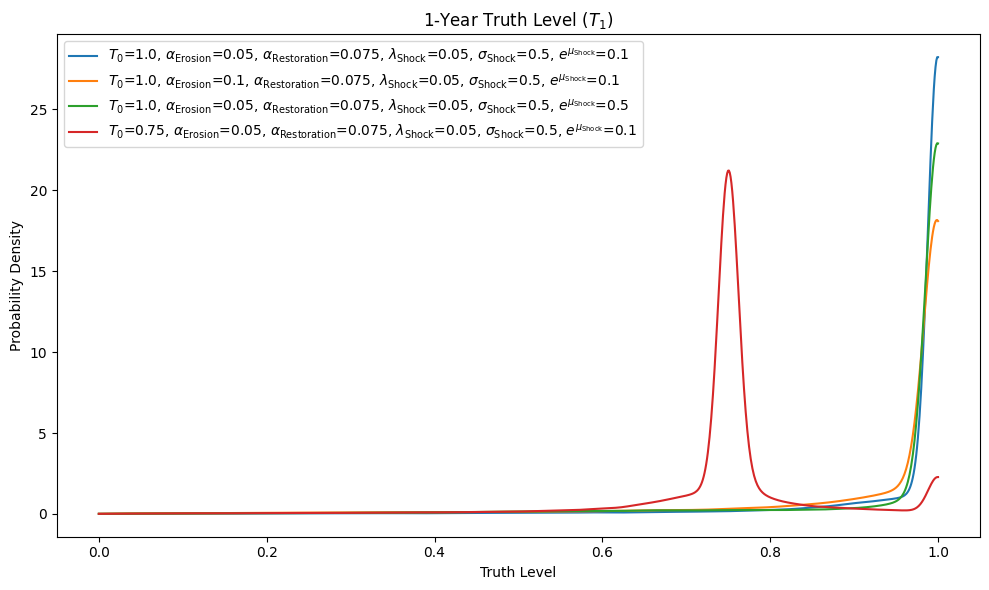

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gamma, nbinom, lognorm


truth_level_params = [r"$T_0$",
                    r"$\alpha_\text{Erosion}$",
                    r"$\alpha_\text{Restoration}$",
                    r"$\lambda_\text{Shock}$",
                    r"$\sigma_\text{Shock}$",
                    r"$e^{\mu_\text{Shock}}$",
                    r"Timeline"]


def sim_truth_level(
        starting_truth,
        erosion_shape,
        restoration_shape,
        shock_λ,
        shock_σ,
        shock_scale,
        timeline='annual',  # can be 'annual' or 'monthly'
        n_sims=10_000
):
    """
    Simulate the Truth Level of knowledge over time using a combination of erosion, restoration, and shock events.

    Parameters:
    - starting_truth: Initial truth level (0 to 1).
    - erosion_shape: Shape parameter for the gamma distribution representing erosion.
    - restoration_shape: Shape parameter for the gamma distribution representing restoration.
    - shock_λ: Shock frequency input for the Poisson model.
    - shock_σ: Standard deviation of the log-normal distribution representing shock severity.
    - shock_scale: Scale parameter of the log-normal distribution representing shock severity.
    - timeline: 'annual' or 'monthly' to indicate the simulation time frame.
    - n_sims: Number of simulations to run.


    Returns:
    - truth_level: Simulated truth level after the specified time period.


    Notes:
    - Parameters must be supplied annualized, even when running monthly simulations.
    """
    if timeline not in ['annual', 'monthly']:
        raise ValueError("Timeline must be either 'annual' or 'monthly'.")

    if timeline == 'annual':
        # Simulate truth drift using a gamma distribution
        erosion_shape = gamma.rvs(erosion_shape, scale=1.0, size=n_sims)

        # Simulate the restoration rate using a gamma distribution
        recovery_rate = gamma.rvs(restoration_shape, scale=1.0, size=n_sims)

        # Simulate the number of shocks using a poisson distribution
        annual_shocks = stats.poisson.rvs(shock_λ, size=n_sims)

        max_shocks = int(annual_shocks.max())
        shock_event_idx = np.arange(max_shocks)
        shock_event_mask = shock_event_idx[None, :] < annual_shocks[:, None]

        # Simulate the amount of shocks using a log-normal distribution
        shock_severities = lognorm.rvs(
            shock_σ, scale=shock_scale, size=(n_sims, max_shocks))
        total_shocks = np.zeros((n_sims, max_shocks))
        total_shocks[shock_event_mask] = shock_severities[shock_event_mask]
        total_shock_rate = total_shocks.sum(axis=1)

        # Combine the effects
        truth_level = starting_truth * \
            np.exp(-erosion_shape + recovery_rate - total_shock_rate)

        # Ensure the truth level is between 0 and 1
        truth_level = np.clip(truth_level, 0.0, 1.0)

        return truth_level
    elif timeline == 'monthly':
        # Simulate truth drift using a gamma distribution
        erosion_shape = gamma.rvs(erosion_shape / 12.0, scale=1.0, size=n_sims)

        # Simulate the restoration rate using a gamma distribution
        recovery_rate = gamma.rvs(
            restoration_shape / 12.0, scale=1.0, size=n_sims)

        # true Poisson thinning for shocks
        monthly_lambda = shock_λ * (1.0 / 12.0)
        monthly_shocks = stats.poisson.rvs(monthly_lambda, size=n_sims)

        if monthly_shocks.size == 0:
            total_shock_rate = 0
        else:
            max_shocks = int(monthly_shocks.max())
            shock_event_idx = np.arange(max_shocks)
            shock_event_mask = shock_event_idx[None, :] < monthly_shocks[:, None]

            # Simulate the amount of shocks using a log-normal distribution
            shock_severities = lognorm.rvs(
                shock_σ, scale=shock_scale, size=(n_sims, max_shocks))
            total_shocks = np.zeros((n_sims, max_shocks))
            total_shocks[shock_event_mask] = shock_severities[shock_event_mask]
            total_shock_rate = total_shocks.sum(axis=1)

        # Combine the effects
        truth_level = starting_truth * \
            np.exp(-erosion_shape + recovery_rate - total_shock_rate)

        # Ensure the truth level is between 0 and 1
        truth_level = np.clip(truth_level, 0.0, 1.0)

        return truth_level
    else:
        raise ValueError("Timeline must be either 'annual' or 'monthly'.")


n_sims = 100_000

truth_params_list = [(1.0, 0.05, 0.075, 0.05, 0.5, 0.1, 'annual'),
                    (1.00, 0.10, 0.075, 0.05, 0.5, 0.1, 'annual'),
                    (1.00, 0.05, 0.075, 0.05, 0.5, 0.5, 'annual'),
                    (0.75, 0.05, 0.075, 0.05, 0.5, 0.1, 'annual'),
                    #(1.00, 0.05, 0.075, 0.05, 0.5, 0.1, 'monthly')
                    ]

# Simulate Truth Level
truth_level_sims = [sim_truth_level(*params, n_sims=n_sims)
                    for params in truth_params_list]
truth_level_kde_list = [stats.gaussian_kde(sim) for sim in truth_level_sims]

# Plot the Truth Level simulation data
plt.figure(figsize=(10, 6))
x = np.linspace(0.0, 1.0, 1000)
for idx, truth_level_dist in enumerate(truth_level_kde_list):
    param_label = ", ".join([f'{truth_level_params[param]}={truth_params_list[idx][param]}' for param in range(
        len(truth_params_list[idx]) - 1)])
    plt.plot(x, truth_level_dist(x), label=param_label)
plt.legend(loc='best')
plt.title('1-Year Truth Level ($T_1$)')
plt.xlabel('Truth Level')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

## Utility & Value
- $V_t=I_t\times U_t\times T_t\times R_t$
  - $V_t$ = Value of knowledge
  - $I_t$ = binary survival of the idea, defined above, measured using $S(t)$
    - $1$ or $0$
  - $U_t$ = Usefulness, maybe a mean-reverting process reflecting how often the knowledge is referenced in decisions.
    - $\ge0$
    - $U_t=\alpha\text{CiteVel}_t+\beta\text{SearchHits}_t$
      - Citation velocity via arXiv / CrossRef API (monthly new citations).
        - Similarly monthly search hits
      - Maybe add down-trend factor when newer competing papers appear.
    - Model as **Ornstein-Uhlenbeck:**
      - $dU_t=\kappa(\bar{U}-U_t)dt+\sigma_U dW_t$
        - mean level $\bar{U}$ itself can drift downward if $T_t$ falls sharply (credibility drag)
  - $T_t$ = Truth level, as above.
    - $\in[0, 1]$
  - $R_t$ = Replaceability (cost to re-learn).
    - $>0$
    - $(0,1)$ for easy
    - $1$ for baseline
    - $>1$ for hard
- Net Present-Value: $\text{NPV} = \int_0^\infty e^{-rt}V_tdt$
  - Exposure base for the Premium

### Utility Model
- Model as **Ornstein-Uhlenbeck:**
    - $dU_t=\kappa(\bar{U}-U_t)dt+\sigma_U dW_t$
    - mean level $\bar{U}$ itself can drift downward if $T_t$ falls sharply (credibility drag)
    - This process at any $t$ is normal with:
      - $\mathbb{E}[U_t]=\bar{U}+(U_0 - \bar{U})e^{-\kappa t}$
      - $\text{Var}[U_t]=\frac{\sigma^2_U}{2\kappa}(1-e^{-2\kappa t})$

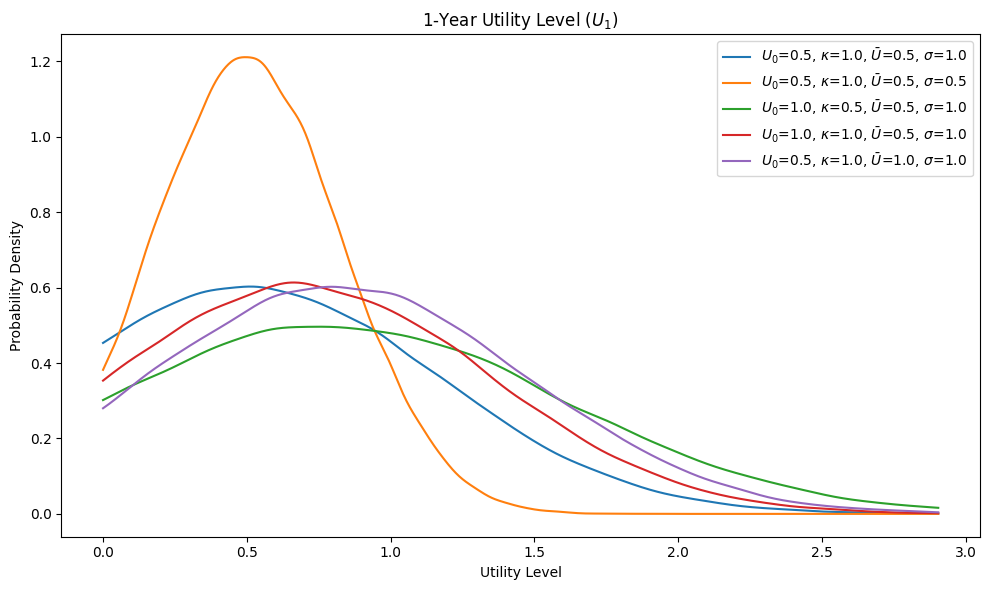

In [3]:
util_level_params = [r"$U_0$", 
                    r"$\kappa$", 
                    r"$\bar{U}$", 
                    r"$\sigma$"]

def sim_util(
        U0,           # starting value
        κ,            # mean-reversion speed
        U_bar,        # long-run mean
        σ,            # volatility
        t = 1.0,      # horizon (year)
        n_sims=10_000 # Monte-Carlo draws
):
    """
    Simulate the Utility Level of knowledge over time using a mean-reverting process.
    Implements the Ornstein-Uhlenbeck process.

    
    Parameters:
    - U0: Initial utility level >=0.
    - κ: Mean-reversion speed >=0.
    - U_bar: Long-run mean utility level >=0.
    - σ: Volatility of the utility level >0.
    - t: Time horizon (in years).
    - n_sims: Number of simulations to run.


    Returns:
    - Ut_dist: Simulated utility level after the specified time period.
    """
    theoretical_mean = U_bar + (U0 - U_bar) * np.exp(-κ * t)
    theoretical_var = σ ** 2 / (2 * κ) * (1 - np.exp(-2 * κ * t))
    Ut_dist = stats.norm.rvs(loc=theoretical_mean, scale=np.sqrt(theoretical_var), size=n_sims)
    return Ut_dist

n_sims = 100_000

util_params_list = [(0.5, 1.0, 0.5, 1.0),
                    (0.5, 1.0, 0.5, 0.5),
                    (1.0, 0.5, 0.5, 1.0),
                    (1.0, 1.0, 0.5, 1.0),
                    (0.5, 1.0, 1.0, 1.0)]

# Simulate Truth Level
util_level_sims = [sim_util(*params, n_sims=n_sims) for params in util_params_list]
util_level_kde_list = [stats.gaussian_kde(sim) for sim in util_level_sims]

# Plot the Utility simulation data
plt.figure(figsize=(10, 6))
x = np.linspace(0, max([np.percentile(sim, 99) * 1.1 for sim in util_level_sims]), 1000)
for idx, util_level_dist in enumerate(util_level_kde_list):
    param_label = ", ".join([f'{util_level_params[param]}={util_params_list[idx][param]}' for param in range(len(util_params_list[idx]))])
    plt.plot(x, util_level_dist(x), label=param_label)
plt.legend(loc='best')
plt.title('1-Year Utility Level ($U_1$)')
plt.xlabel('Utility Level')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

### Calculate Net Present-Value
- $\text{NPV} = \int_0^\infty e^{-rt}V_tdt$
  - Exposure base for the Premium
- TODO: Why is the NPV so low? It should be about 20x more
  - Is there an inaccurate accounting for dt?

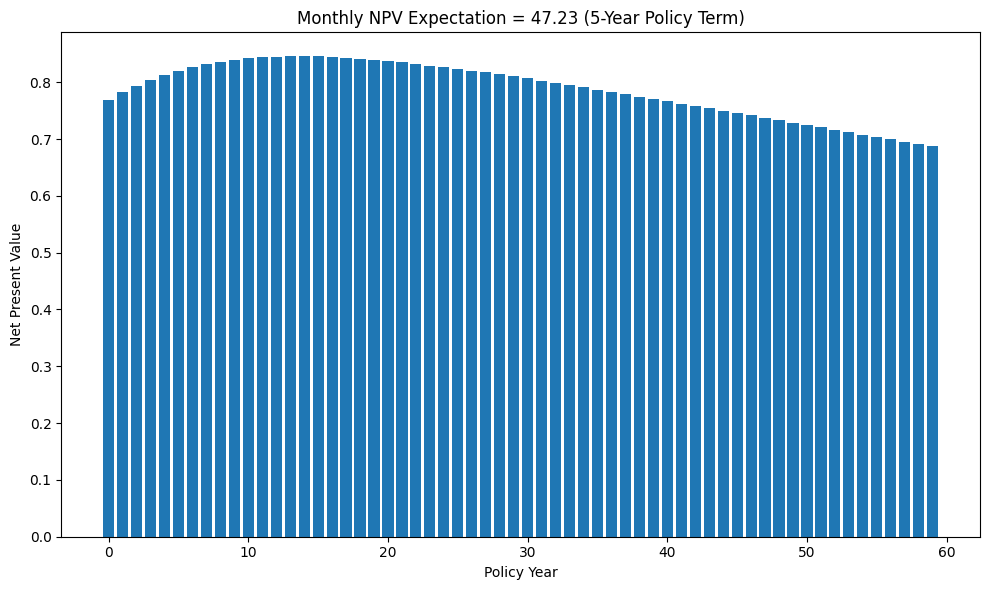

In [4]:
def calculate_value(
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    years=5,  # Time horizon (in integer years)
    n_sims=10_000  # Number of Monte Carlo simulations
):
    """
    Calculate the value over time V_t of a covered piece of knowledge.
    This serves as the policy exposure.

    Returns:
    - monthly_all: shape (years * 12, n_sims) of all sim paths
    """
    n_months = int(years * 12)
    dt = 1 / 12.0

    # unpack
    U0 = utility_params['U0']
    kappa = utility_params['kappa']
    U_bar = utility_params['U_bar']
    sigma = utility_params['sigma']

    erosion_shape = truth_params['erosion_shape']
    restoration_shape = truth_params['restoration_shape']
    shock_lambda = truth_params['shock_lambda']
    shock_sigma = truth_params['shock_sigma']
    shock_scale = truth_params['shock_scale']

    # initialize arrays to track simulations
    util = np.full(n_sims, U0)
    truth = np.full(n_sims, starting_truth)

    # pre-allocate
    monthly_all = np.zeros((n_months, n_sims))
    util_all = np.zeros((n_months, n_sims))
    truth_all = np.zeros((n_months, n_sims))

    for month in range(n_months):
        # OU step for U
        dW = np.random.randn(n_sims) * np.sqrt(dt)
        util += kappa * (U_bar - util) * dt + sigma * dW

        # truth step
        truth = sim_truth_level(
            truth,
            erosion_shape,
            restoration_shape,
            shock_lambda,
            shock_sigma,
            shock_scale,
            timeline='monthly',
            n_sims=n_sims
        )

        # track NPV for each sim
        monthly_all[month] = util * truth * replaceability
        util_all[month] = util
        truth_all[month] = truth

    # average across sims
    monthly_mean = monthly_all.mean(axis=1)
    return monthly_all, util_all, truth_all

def calculate_exposure(
    discount_rate,  # Discount rate
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    years=5,  # Time horizon (in integer years)
    n_sims=10_000  # Number of Monte Carlo simulations
):
    """
    Calculate the Net Present Value (NPV) of a covered piece of knowledge.
    This serves as the policy exposure.

    Returns:
    - monthly_mean: average NPV per month (length years * 12)
    - monthly_all: shape (years * 12, n_sims) of all sim paths
    """
    n_months = years * 12
    dt = 1 / 12.0

    monthly_all_undiscounted, util_all, truth_all = calculate_value(
        utility_params=utility_params, 
        starting_truth=starting_truth,
        truth_params=truth_params,
        replaceability=replaceability,
        years=years,
        n_sims=n_sims)

    monthly_all_discounted = np.zeros(monthly_all_undiscounted.shape)
    for month in range(n_months):
        # track NPV for each sim
        monthly_discount_rate = (1 + discount_rate) ** (month * dt)
        monthly_all_discounted[month] = monthly_all_undiscounted[month] / monthly_discount_rate

    # average across sims
    monthly_mean = monthly_all_discounted.mean(axis=1)
    return monthly_mean, monthly_all_discounted, monthly_all_undiscounted, util_all, truth_all


discount_rate = 0.045
utility_params = {
    'U0' : 0.75,
    'kappa' : 1.0,
    'U_bar' : 1.0,
    'sigma' : 0.25
}
starting_truth = 1.0
truth_params = {
    'erosion_shape' : 0.05,
    'restoration_shape' : 0.075,
    'shock_lambda' : 0.05,
    'shock_sigma' : 0.5,
    'shock_scale' : 0.1
}
replaceability = 1.0
policy_duration = 5  # years
n_sims = 100_000

monthly_mean, _, _, _, _ = calculate_exposure(discount_rate,
                                            utility_params,
                                            starting_truth,
                                            truth_params,
                                            replaceability,
                                            policy_duration,
                                            n_sims=n_sims)

print()

x = range(policy_duration * 12)

# Plot the NPV expectation data
plt.figure(figsize=(10, 6))
plt.bar(x, monthly_mean)
# plt.legend(loc='best')
plt.title(f'Monthly NPV Expectation = {sum(monthly_mean):,.2f} ({policy_duration}-Year Policy Term)')
plt.xlabel('Policy Year')
plt.ylabel('Net Present Value')
plt.tight_layout()
plt.show()

## Portfolio Effects
- Tail dependence using copulas, Gumbel
- Selection bias - insureds may only buy cover on dubious knowledge, so we have anti-selection.
  - Underwriting questions?

## Product Design Ideas
- Verification Costs ~ "First-party loss", pays for replication studies, fact-checking reviews. Frequency is high, severity mid.
- Decision Error Liability ~ "E&O cover", third-party liability when bad knowledge causes client harm. Low frequency, fat-tail severity.
- Depreciation guarantee ~ "Depreciation stop-loss". If NPV of knowledge drops > X% within Y years, indemnify. Parametric trigger using agreed NPV index.
  - Retention/deductible expressed as an *evidence budget* the insured must spend before claiming indemnity.

## Focus: Knowledge Depreciation Guarantee (KDG)
- Parametric, cover worst-case drop in a 3-month window subject to deductible and limit.

### Trigger Design
- **Index:** rolling value $V_t$
- **Strike:** e.g., 30% drop from baseline within a three-year window.
  - **So the policy duration will be about 5 years.**
- **Deductible:** the policyholder must self-fund the first X% of loss.

In [124]:
def calculate_kdg_payout(
    # -----------------
    # Value parameters
    # -----------------
    utility_params,  # Utility parameters (U0, kappa, U_bar, sigma)
    starting_truth,  # Starting truth level (T0)
    # Truth parameters (T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock)
    truth_params,
    replaceability=1.0,  # Cost to re-learn (1.0 is baseline, >1 is hard)
    # ---------------
    # Policy Details
    # ---------------
    trigger_duration=3.0,   # in years
    trigger_threshold=0.30,  # % drop over the duration
    policy_years=5.0,       # in years
    deductible=0.20,        # deductible as a % of initial value (0.0 to 1.0)
    limit=2.0,             # limit as a % of initial value (0.0 to 1.0)
    discount_rate=0.045,    # Discount rate per year
    n_sims=10_000           # Number of Monte Carlo simulations
):
    """
    Calculate the payout of a Knowledge Depreciation Guarantee (KDG) policy.
    This is a function to calculate the payout of a KDG policy based on the utility level and truth level.
    The payout is based on the difference between the utility level and truth level over a specified period.
    The payout is triggered if the utility level drops below a certain threshold compared to the truth level.


    Parameters:
    - utility_params: List of utility parameters [U0, kappa, U_bar, sigma].
    - starting_truth: Initial truth level (T0).
    - truth_params: List of truth parameters [T0, alpha_erosion, alpha_restoration, r_shock, p_shock, sigma_shock, scale_shock].
    - replaceability: Cost to re-learn (1.0 is baseline, >1 is hard).
    - trigger_duration: Duration of the trigger condition (in years).
    - trigger_threshold: Threshold for the trigger condition (0.0 to 1.0).
    - policy_years: Duration of the policy (in years).
    - deductible: Deductible amount as a percentage of the initial value (0.0 to 1.0).
    - limit: Limit amount as a percentage of the initial value (0.0 to 1.0).
    - discount_rate: Discount rate per year.
    - n_sims: Number of Monte Carlo simulations.


    Returns:
    """
    exposure, monthly_all_disc, monthly_all, util_all, truth_all = calculate_exposure(discount_rate,
                                                                                    utility_params,
                                                                                    starting_truth,
                                                                                    truth_params,
                                                                                    replaceability,
                                                                                    policy_duration,
                                                                                    n_sims=n_sims)

    n_months = int(policy_years * 12)
    dt = 1 / 12.0
    lookback = int(trigger_duration * 12)
    monthly_discount_rates = (1 + discount_rate) ** (-np.arange(n_months) * dt)

    # V_0
    initial_index = monthly_all[0:3].mean(axis=0) # use a 3-month average for value
    ded_amt = initial_index * deductible
    lim_amt = initial_index * limit if limit is not None else None

    past_vals = monthly_all[:-lookback]
    now_vals = monthly_all[lookback:]
    pct_drops = np.where(past_vals == 0, 0, (past_vals - now_vals) / past_vals)
    pct_drops = np.where(pct_drops >= trigger_threshold, pct_drops, 0.0)

    # Find the worst drop per path and its month index
    worst_pct = pct_drops.max(axis=0)

    loss_nominal = worst_pct * initial_index
    loss_net = np.maximum(0, loss_nominal - ded_amt)
    nominal_payout = np.minimum(loss_net, lim_amt)

    # shift to original month index
    worst_month = pct_drops.argmax(axis=0) + lookback
    worst_month = np.where((worst_month == lookback) & (nominal_payout < 1e-6), -1, worst_month)

    payout_mask = (worst_month > -1) & (nominal_payout >= 1e-6)
    pv_payout = np.zeros(len(nominal_payout))
    pv_payout[payout_mask] = nominal_payout[payout_mask] * monthly_discount_rates[worst_month[payout_mask]]

    # # Make sure there are no -1 worst months with payouts
    # for i in range(len(nominal_payout)):
    #     if worst_month[i] == -1 and nominal_payout[i] >= 1e-6:
    #         print(i, worst_month[i], nominal_payout[i], pv_payout[i], monthly_discount_rates[worst_month[i]])

    return {
        "gross_paths":    nominal_payout,
        "pv_paths":       pv_payout,
        "exposure":       exposure,
        "initial_index":  initial_index.mean(),
        "pure_premium":   pv_payout.mean(),
        "monthly_values": monthly_all,
        "utility_paths": util_all,
        "truth_paths":   truth_all,
        "worst_payout_month": worst_month
    }


utility_params = {
    'U0' : 0.75,
    'kappa' : 1.0,
    'U_bar' : 1.0,
    'sigma' : 0.25
}
starting_truth = 1.0
truth_params = {
    'erosion_shape' : 0.05,
    'restoration_shape' : 0.075,
    'shock_lambda' : 0.05,
    'shock_sigma' : 0.5,
    'shock_scale' : 0.1
}
replaceability = 1.0
trigger_duration = 3.0   # in years
trigger_threshold = 0.30  # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
n_sims = 100_000

kdg_results_dict = calculate_kdg_payout(utility_params,
                                        starting_truth,
                                        truth_params,
                                        replaceability,
                                        trigger_duration=trigger_duration,
                                        trigger_threshold=trigger_threshold,
                                        policy_years=policy_years,
                                        deductible=deductible,
                                        limit=limit,
                                        discount_rate=discount_rate,
                                        n_sims=n_sims)


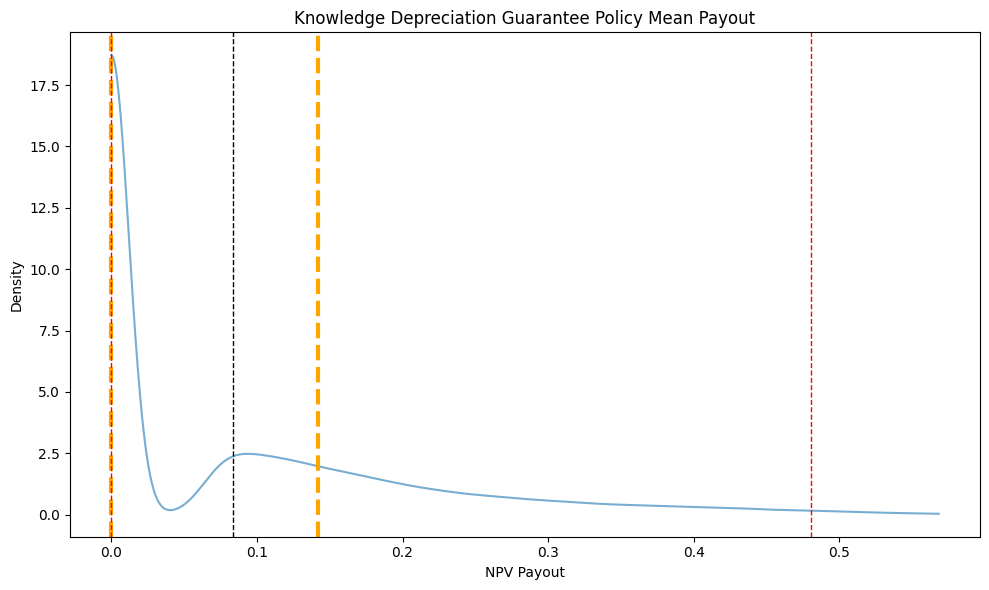

In [125]:
total_npv_payout_sims = kdg_results_dict['pv_paths']
total_npv_payout_sims_kde = stats.gaussian_kde(total_npv_payout_sims)

# Plot the Payout simulation means
plt.figure(figsize=(10, 6))
x = np.linspace(0, np.percentile(total_npv_payout_sims, 99.5) * 1.1, 1000)
plt.plot(x, total_npv_payout_sims_kde(x), alpha=0.6)
plt.axvline(total_npv_payout_sims.mean(), color='k', linestyle='dashed', linewidth=1)
# 50% CI
plt.axvline(np.percentile(total_npv_payout_sims, 25), color='orange', linestyle='dashed', linewidth=3)
plt.axvline(np.percentile(total_npv_payout_sims, 75), color='orange', linestyle='dashed', linewidth=3)
# 98% CI
plt.axvline(np.percentile(total_npv_payout_sims, 1), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(total_npv_payout_sims, 99), color='r', linestyle='dashed', linewidth=1)
plt.title('Knowledge Depreciation Guarantee Policy Mean Payout')
plt.xlabel('NPV Payout')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Pricing Flow
- **Exposure base:** initial index value $V_0$ or average over first quarter.
- **Loss distribution:** run Monte-Carlo on the full coupled system $(I, T, U)$ to get annual loss $L$.
- **Pure Premium:** $\mathbb{E}[L|\text{deductible, limit}]$
- **Risk Load:** $\text{Capital Cost + parametric risk on }\lambda, \alpha,\text{ etc.}$
- **Capital Cost:** $\text{CoC}\times\text{SCR (1-in-200 depreciation event)}=\text{CoC}\times\text{TVaR}_{99.5\%}$

In [106]:
utility_params = {
    'U0' : 0.75,
    'kappa' : 1.0,
    'U_bar' : 1.0,
    'sigma' : 0.15
}
starting_truth = 1.0
truth_params = {
    'erosion_shape' : 0.05,
    'restoration_shape' : 0.075,
    'shock_lambda' : 0.02,
    'shock_sigma' : 0.5,
    'shock_scale' : 0.1
}
replaceability = 1.0     # Cost to re-learn (1.0 is baseline, >1 is hard)
trigger_duration = 3.0   # in years
trigger_threshold = 0.30 # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
n_sims = 100_000

kdg_results_dict = calculate_kdg_payout(utility_params,
                                        starting_truth,
                                        truth_params,
                                        replaceability,
                                        trigger_duration=trigger_duration,
                                        trigger_threshold=trigger_threshold,
                                        policy_years=policy_years,
                                        deductible=deductible,
                                        limit=limit,
                                        discount_rate=discount_rate,
                                        n_sims=n_sims)

cost_of_capital = 0.07
total_npv_payout_sims = kdg_results_dict['pv_paths']
pure_premium = kdg_results_dict['pure_premium']
VaR_99_5 = np.percentile(total_npv_payout_sims, 99.5)
parameter_risk = 0 # TODO: estimate
risk_margin = cost_of_capital * VaR_99_5
print("Initial Price: ", kdg_results_dict['initial_index'])
print("Pure Premium: ", pure_premium)
print("Risk Margin: ", risk_margin)

Initial Price:  0.7847859801798457
Pure Premium:  0.04820238264811422
Risk Margin:  0.03464252465564941


### Moral Hazard Levers
- **Parametric recoveries:** Payout is automatic when index hits strike; reduces disputes but forces transparent index constrction.
- **Evidence maintenance clause:** Require periodic replication or citation-audit. Non-compliance raises deductible.
- **Experience rating:** Post-loss surcharge on future premium if insured's own corrections lagged.
- **Co-insurance on *truth recovery* costs:** Insured shares 20-30% of replication spend to get skin in the game.
- **Real-time monitoring:** Pull citation velocity directly; premium credits for upward trends.

## Pricing Sketch ("Actuarial Cost of Truth")
- Exposure base: $\mathbb{E}[\text{NPV}]$.
- Frequency-Severity simulation of decay & shocks to get an annual loss distribution per $1 NPV.
- Risk load:
  - **Parametric Risk:** Baysian posterior on $p, \alpha, \lambda, \text{etc.}$, add a credibility margin.
  - **Model risk:** Stress alternate decau regimes (paradigm shift) and take Tail-VaR (e.g., 99.5th percentile).
- **Cost of Capital:** CoC * SCR (Solvency II-style). For intellectual assets, let SCR be driven by 1-in-200 utility collapse.
- **Premium:** $\text{Pure Premium}+\text{Risk Load}+\text{Expense}+\text{Profit}$.
  - $\Pi=\mathbb{E}[L]+k\text{TVaR}_{99.5\%}(L)+\text{Exp}+\text{Profit}$
  - $L$=simulated loss ratio.
  - $k\approx$ weighted average cost of capital.

## Implementation Sketch

1. Select corpus (DOI / arXiv IDs list) peer-reviewed
2. Baseline measurement
   - $U_0$ = citation_velocity(start)
   - $T_0$ = 1 (assumed peer-reviewed)
   - $V_0 = U_0\times T_0$
3. Monthly update loop:
   1. Pull new citations $\Delta U$
   2. Scrape retraction / erratum databases, shock arrivals $Z_i$
   3. Update $U_t$ via OU step
   4. Udate $D_t, J_t, \text{Recovery}_t$
   5. Compute $V_t=I_t\times U_t\times T_t$
   6. Check depreciation trigger
4. Premium refresh annually(?) with credibility-weighted posterior on $(\lambda,\kappa,\sigma_\text{U},\alpha_\text{drift},...)$.
   - Is this annually or every 5 years?

## Roadmap Post-Implementation
- **Calibrate U-process** from a sample of arXiv categories to get $\kappa$ and $\sigma_U$
- **Estimate shock severity** distribution Z from Retraction Watch data (lognormal heavy tail fits nicely).
- **Blend survival:** fit Kaplan-Meier to "time-to-major-revision" for textbooks or RFCs, then add a Pareto tail for the beyond-data horizon.
- **Prototype pricing:** small Python Month-Carlo for a single article's KDG with 30% trigger, 10% deductible, USD $1M limit.

## Portfolio Simulation Using Hierarchical Models

### Set up the Hyperparameters

In [107]:
##########################
# Utility Hyperparameters
##########################
# U0 hyperparameters - normal
U0_mu = 0.75
U0_sigma = 0.1

# kappa hyperparameters - normal
kappa_mu = 1.0
kappa_sigma = 0.25

# U_bar hyperparameters - normal
U_bar_mu = 1.0
U_bar_sigma = 0.25

# sigma hyperparameters - normal
sigma_mu = 0.15
sigma_sigma = 0.05

########################
# Truth Hyperparameters
########################
# starting_truth hyperparameters - gamma
# Model: 1.0 - gamma(1.5, 0.1)
starting_truth_shape = 1.5
starting_truth_scale = 0.1

# erosion_shape hyperparameters - lognormal
erosion_shape_mu = np.log(0.05)
erosion_shape_sigma = 0.02

# restoration_shape hyperparameters - lognormal
restoration_shape_mu = np.log(0.075)
restoration_shape_sigma = 0.02

# shock_lambda hyperparameters - gamma
shock_lambda_shape = 1.5
shock_lambda_scale = 0.02 / 1.5

# shock_sigma hyperparameters - normal
shock_sigma_mu = 0.5
shock_sigma_sigma = 0.1

# shock_scale hyperparameters - normal
shock_scale_mu = 0.1
shock_scale_sigma = 0.02

#################################
# Replaceability Hyperparameters - lognormal
#################################
replaceability_mu = np.log(1.0)
replaceability_sigma = 0.25

#####################
# Policy Assumptions
#####################
trigger_duration = 3.0   # in years
trigger_threshold = 0.30 # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
cost_of_capital = 0.07
n_sims = 100_000

n_assets = 1_000

rng = np.random.default_rng(42)

assets = {}
for i in range(n_assets):
    assets[i] = {
        'utility_params' : {
            'U0' : rng.normal(U0_mu, U0_sigma),
            'kappa' : rng.normal(kappa_mu, kappa_sigma),
            'U_bar' : rng.normal(U_bar_mu, U_bar_sigma),
            'sigma' : rng.normal(sigma_mu, sigma_sigma)
        },
        'starting_truth' : 1.0 - rng.gamma(starting_truth_shape, starting_truth_scale),
        'truth_params' : {
            'erosion_shape' : rng.lognormal(erosion_shape_mu, erosion_shape_sigma),
            'restoration_shape' : rng.lognormal(restoration_shape_mu, restoration_shape_sigma),
            'shock_lambda' : rng.gamma(shock_lambda_shape, shock_lambda_scale),
            'shock_sigma' : rng.normal(shock_sigma_mu, shock_sigma_sigma),
            'shock_scale' : rng.normal(shock_scale_mu, shock_scale_sigma)
        },
        'replaceability' : rng.lognormal(replaceability_mu, replaceability_sigma)
    }


In [ ]:

initial_prices = np.zeros(n_assets)
pure_premiums = np.zeros(n_assets)
risk_margins = np.zeros(n_assets)
for i in range(n_assets):
    kdg_results_dict = calculate_kdg_payout(assets[i]['utility_params'],
                                            assets[i]['starting_truth'],
                                            assets[i]['truth_params'],
                                            assets[i]['replaceability'],
                                            trigger_duration=trigger_duration,
                                            trigger_threshold=trigger_threshold,
                                            policy_years=policy_years,
                                            deductible=deductible,
                                            limit=limit,
                                            discount_rate=discount_rate,
                                            n_sims=n_sims)
    
    total_npv_payout_sims = kdg_results_dict['pv_paths']
    pure_premium = kdg_results_dict['pure_premium']
    VaR_99_5 = np.percentile(total_npv_payout_sims, 99.5)
    risk_margin = cost_of_capital * VaR_99_5 + parameter_risk
    initial_prices[i] = kdg_results_dict['initial_index']
    pure_premiums[i] = pure_premium
    risk_margins[i] = risk_margin


[10.43585812 15.20655961  8.90345518 10.22035633 14.27006142  9.78792645
 11.01582451 13.92521146  8.40792501  9.90771211 15.67567063 12.23120272
 13.94474555  9.89592435  9.51875954 10.20191385 16.1599833  10.08493143
  9.22075038 15.1786514   9.43527237 10.06528879 11.15348796 23.07178109
 10.0265967  25.36321286  8.94949426  9.18158217 16.09266005 13.95736807
 10.25853961 12.68814173 13.61935983  8.54147892 12.74638613  9.2904795
 11.24002791 14.67875847  9.75299341 16.76648238 13.02657541 13.46797995
  9.74522568  9.57286275 21.57209507 12.22518549 13.680263    9.45490577
  8.76389427 21.37553399 13.78737509  8.90474728 10.34827748 10.96147489
  9.72347324  9.15196799  9.38335216  9.80303896  9.26657131 10.10088234
 17.10905931  9.84979528  9.49596519  9.0517444  11.57049571  8.88912857
  8.9108602   9.63566047 10.82369745  8.49150592  9.99934438 15.30763378
 13.03006187 24.79656678 10.62136959  8.61207304 13.71052387 13.12911685
 12.83788952 10.49494187  9.6553409  21.66578481 11.

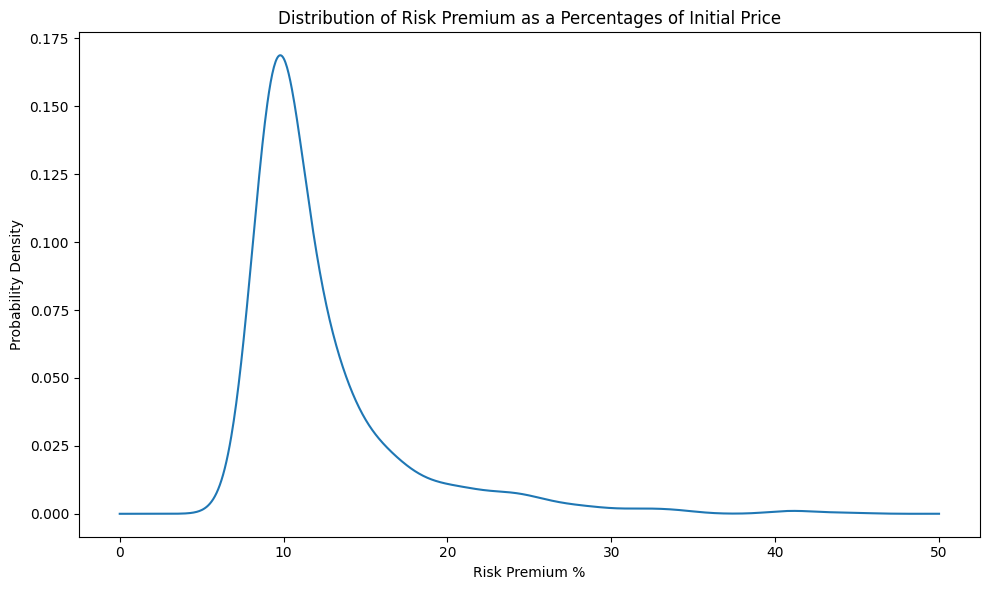

In [66]:

risk_premium_pct = (pure_premiums + risk_margins) / initial_prices * 100.0
risk_premium_pct_kde = stats.gaussian_kde(risk_premium_pct)

print(risk_premium_pct)

# Plot the Risk Premium Percentage to assess viability
plt.figure(figsize=(10, 6))
x = np.linspace(0.0, 50.0, 1000)
plt.plot(x, risk_premium_pct_kde(x))
# plt.legend(loc='best')
plt.title('Distribution of Risk Premium as a Percentages of Initial Price')
plt.xlabel('Risk Premium %')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

In [55]:
print(risk_premium_pct.mean())

12.345740520913107


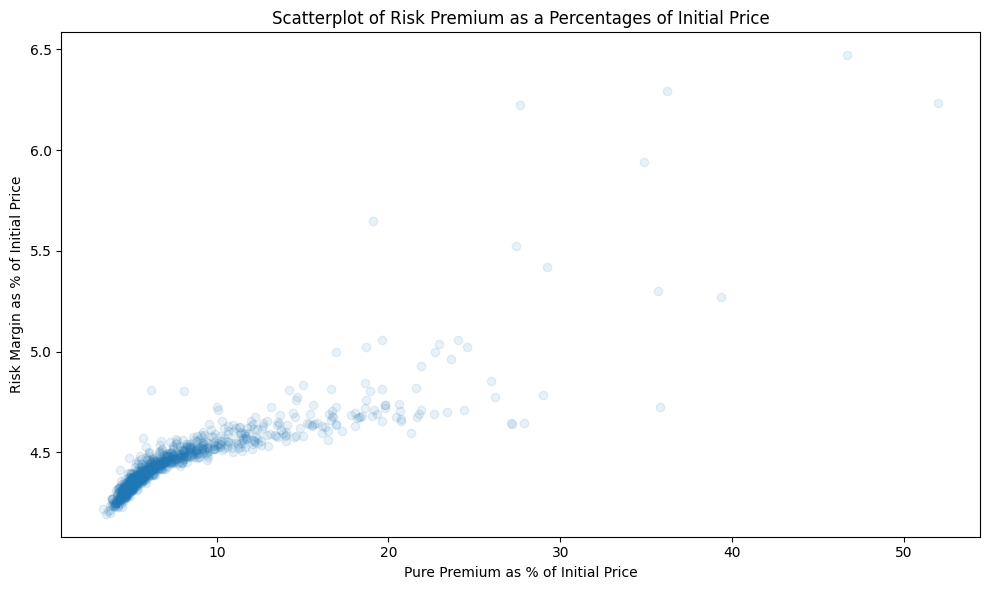

In [64]:
pure_premium_pct = pure_premiums / initial_prices * 100
risk_margin_pct = risk_margins / initial_prices * 100

plt.figure(figsize=(10, 6))
plt.scatter(pure_premium_pct, risk_margin_pct, alpha=0.1)
# plt.legend(loc='best')
plt.title('Scatterplot of Risk Premium as a Percentages of Initial Price')
plt.xlabel('Pure Premium as % of Initial Price')
plt.ylabel('Risk Margin as % of Initial Price')
plt.tight_layout()
plt.show()

## Reserving

### Simulate 15 Years of Assets of a Growing Book

In [181]:
rng = np.random.default_rng(42)

#####################
# Policy Assumptions
#####################
# Changed the trigger_duration to be 2 years for production
trigger_duration = 2.0   # in years
trigger_threshold = 0.30 # % drop over the duration
policy_years = 5.0       # in years
deductible = 0.20        # deductible as a % of initial value (0.0 to 1.0)
limit = 1.0              # limit as a % of initial value (0.0 to 1.0)
discount_rate = 0.045
cost_of_capital = 0.07

########################
# Reserving Assumptions
########################
min_assets_in_year = 100
max_assets_in_year = 700
n_years = 15
n_sims = 1 # only one outcome simulation per asset

assets_issued_per_year = rng.integers(min_assets_in_year, max_assets_in_year + 1, n_years)  # Use rng.integers instead of rng.random_integers

assets_issued_per_year.sort()
assets_issued_per_year

array([151, 153, 156, 221, 360, 363, 416, 493, 519, 531, 542, 557, 565,
       616, 686])

In [ ]:
import json

assets_for_reserving_file = 'assets_over_n_years.json'

with open(assets_for_reserving_file, 'w') as f:
    f.write('[\n')  # Start the JSON array

for year, assets_in_year in enumerate(assets_issued_per_year):
    for asset in range(assets_in_year):
        # Generate asset parameters
        asset_info = {
            'year' : year + 1,
            'asset_id' : f'{(year + 1)}-{(asset + 1)}',
            'utility_params' : {
                'U0' : rng.normal(U0_mu, U0_sigma),
                'kappa' : rng.normal(kappa_mu, kappa_sigma),
                'U_bar' : rng.normal(U_bar_mu, U_bar_sigma),
                'sigma' : rng.normal(sigma_mu, sigma_sigma)
            },
            'starting_truth' : 1.0 - rng.gamma(starting_truth_shape, starting_truth_scale),
            'truth_params' : {
                'erosion_shape' : rng.lognormal(erosion_shape_mu, erosion_shape_sigma),
                'restoration_shape' : rng.lognormal(restoration_shape_mu, restoration_shape_sigma),
                'shock_lambda' : rng.gamma(shock_lambda_shape, shock_lambda_scale),
                'shock_sigma' : rng.normal(shock_sigma_mu, shock_sigma_sigma),
                'shock_scale' : rng.normal(shock_scale_mu, shock_scale_sigma)
            },
            'replaceability' : rng.lognormal(replaceability_mu, replaceability_sigma)
        }

        # Model asset performance
        kdg_results_dict = calculate_kdg_payout(asset_info['utility_params'],
                                                asset_info['starting_truth'],
                                                asset_info['truth_params'],
                                                asset_info['replaceability'],
                                                trigger_duration=trigger_duration,
                                                trigger_threshold=trigger_threshold,
                                                policy_years=policy_years,
                                                deductible=deductible,
                                                limit=limit,
                                                discount_rate=discount_rate,
                                                n_sims=n_sims)
        asset_info['results'] = kdg_results_dict

        # Write to JSON file
        with open(assets_for_reserving_file, 'a') as f:
            json.dump(asset_info, f, default=lambda o: o.tolist() if isinstance(o, np.ndarray) else o)
            f.write(',\n')

with open(assets_for_reserving_file, 'a') as f:
    # remove last comma from the file
    # f.seek(f.tell() - 2, 0)  # Move the cursor to the second last character
    # f.truncate()  # Truncate the file to remove the last comma and newline
    # End the JSON array
    f.write(']')


C:\Users\alexf\AppData\Local\Temp\ipykernel_18620\522235460.py:64: RuntimeWarning: invalid value encountered in divide
  pct_drops = np.where(past_vals == 0, 0, (past_vals - now_vals) / past_vals)


In [184]:
import json

assets_for_reserving_file = 'assets_over_n_years.json'

# Load the JSON file into a variable
with open(assets_for_reserving_file, 'r') as f:
    assets_over_n_years = json.load(f)

# Now the variable `assets_over_n_years` contains the data from the JSON file

In [509]:
import numpy as np
import pandas as pd


# Assume January 1st Policy inception
dev_triangle_payouts = {}

# These should correspond to the exposures
initial_indices = {}

# Process payouts into development triangle dictionary
for asset in assets_over_n_years:
    payout_month = asset['results']['worst_payout_month'][0]
    payout_month_ending = int(payout_month / 12) * 12

    if asset['year'] not in dev_triangle_payouts.keys():
        # Track the exposure via the initial index
        initial_indices[asset['year']] = np.sum(asset['results']['initial_index'])

        if payout_month == -1:
            continue
        # Create a new entry for the Policy Year (PY) in the triangle dictionary
        dev_triangle_payouts[asset['year']] = {}
        dev_triangle_payouts[asset['year']][payout_month_ending] = asset['results']['gross_paths'][0]
    else:
        # Track the exposure via the initial index
        initial_indices[asset['year']] += asset['results']['initial_index']

        if payout_month == -1:
            continue
        # Track the Policy Year (PY) development in the triangle dictionary
        if payout_month_ending not in dev_triangle_payouts[asset['year']].keys():
            dev_triangle_payouts[asset['year']][payout_month_ending] = asset['results']['gross_paths'][0]
        else:
            dev_triangle_payouts[asset['year']][payout_month_ending] += asset['results']['gross_paths'][0]

print(dev_triangle_payouts)
print(initial_indices)


{1: {48: 3.886298147207554, 24: 2.890756884242961, 36: 1.7444718246661106}, 2: {48: 3.6210397890962347, 24: 3.543557118392087, 36: 1.7191878792096447}, 3: {36: 3.950449756092036, 48: 5.014525014698062, 24: 2.813820212117127}, 4: {24: 7.137082283795595, 48: 6.434540960974772, 36: 4.335105793553133}, 5: {24: 10.775301245434614, 48: 10.133562098200114, 36: 6.3284928257622655}, 6: {48: 12.048073330017822, 24: 7.690671506432652, 36: 7.179524293305867}, 7: {48: 10.053520902355563, 24: 10.425501309328808, 36: 7.29727147303126}, 8: {48: 15.13425650316261, 36: 9.618522644684607, 24: 13.592505628931185}, 9: {24: 10.876762227893272, 48: 18.20809269241243, 36: 7.991102636775303}, 10: {48: 15.888225921476494, 24: 11.491719894220418, 36: 8.766631655660618}, 11: {48: 17.19814016032862, 24: 13.002814337490483, 36: 11.566850541250439}, 12: {36: 10.5259317663651, 24: 12.762833214815473, 48: 18.282514564354987}, 13: {24: 13.23640043984797, 36: 11.395673859609229, 48: 15.413120848979688}, 14: {48: 20.2058

### Analyze the Data as of 12/31/2035

#### Develop Losses to Ultimates

In [510]:
# Let 1 unit of value exposure = $100K
exposure_scale = 100_000
policy_year_0 = 2025

dev_triangle_dict_for_pd = []
for policy_year_idx, payout_dict in dev_triangle_payouts.items():
    policy_year = policy_year_0 + policy_year_idx
    exposure = initial_indices[policy_year_idx]
    # placeholders
    for month_end_idx in range(int(policy_years)):
        payout_year = int(month_end_idx + policy_year)
        dev_triangle_dict_for_pd.append({
            'Policy Year': policy_year,
            'Payout Year': payout_year,
            'Incurred': 0.0,
            'Exposure': exposure * exposure_scale,
            'Ratio': 0.0
        })

# turn into DataFrame
dev_triangle_df = pd.DataFrame(dev_triangle_dict_for_pd)

# now fill in actual payouts
for policy_year_idx, payout_dict in dev_triangle_payouts.items():
    policy_year = policy_year_0 + policy_year_idx
    for month_end_idx, payout in payout_dict.items():
        payout_year = int(month_end_idx / 12.0 + policy_year)
        mask = (dev_triangle_df['Policy Year']==policy_year) & (dev_triangle_df['Payout Year']==payout_year)
        dev_triangle_df.loc[mask, 'Incurred']  = payout * exposure_scale
        dev_triangle_df.loc[mask, 'Ratio']    = payout / exposure

# Narrow down to available experience (through year-end 2033)
dev_triangle_available_df = dev_triangle_df[(dev_triangle_df['Policy Year'] <= 2035) & 
                                            (dev_triangle_df['Payout Year'] <= 2035)].copy()

dev_triangle_available_df

,Policy Year,Payout Year,Incurred,Exposure,Ratio
0,2026,2026,0.000000e+00,1.024770e+07,0.000000
1,2026,2027,0.000000e+00,1.024770e+07,0.000000
2,2026,2028,2.890757e+05,1.024770e+07,0.006244
3,2026,2029,1.744472e+05,1.024770e+07,0.003768
4,2026,2030,3.886298e+05,1.024770e+07,0.008394
5,2027,2027,0.000000e+00,1.025357e+07,0.000000
6,2027,2028,0.000000e+00,1.025357e+07,0.000000
7,2027,2029,3.543557e+05,1.025357e+07,0.007654
8,2027,2030,1.719188e+05,1.025357e+07,0.003713
9,2027,2031,3.621040e+05,1.025357e+07,0.007821


In [511]:
dev_triangle_available_df.sort_values(by=['Policy Year', 'Payout Year'], inplace=True)
dev_triangle_available_df['Cumulative Incurred'] = dev_triangle_available_df.groupby('Policy Year')['Incurred'].cumsum()

In [529]:
dev_triangle_available_df

,Policy Year,Payout Year,Incurred,Exposure,Ratio,Cumulative Incurred
0,2026,2026,0.000000e+00,1.024770e+07,0.000000,0.000000e+00
1,2026,2027,0.000000e+00,1.024770e+07,0.000000,0.000000e+00
2,2026,2028,2.890757e+05,1.024770e+07,0.006244,2.890757e+05
3,2026,2029,1.744472e+05,1.024770e+07,0.003768,4.635229e+05
4,2026,2030,3.886298e+05,1.024770e+07,0.008394,8.521527e+05
5,2027,2027,0.000000e+00,1.025357e+07,0.000000,0.000000e+00
6,2027,2028,0.000000e+00,1.025357e+07,0.000000,0.000000e+00
7,2027,2029,3.543557e+05,1.025357e+07,0.007654,3.543557e+05
8,2027,2030,1.719188e+05,1.025357e+07,0.003713,5.262745e+05
9,2027,2031,3.621040e+05,1.025357e+07,0.007821,8.883785e+05


In [535]:
import chainladder as cl
import matplotlib.pyplot as plt

# Create the triangle
triangle = cl.Triangle(dev_triangle_available_df, 
                        origin='Policy Year', 
                        development='Payout Year', 
                        columns=['Incurred'],
                        cumulative=False)
triangle = triangle.incr_to_cum()

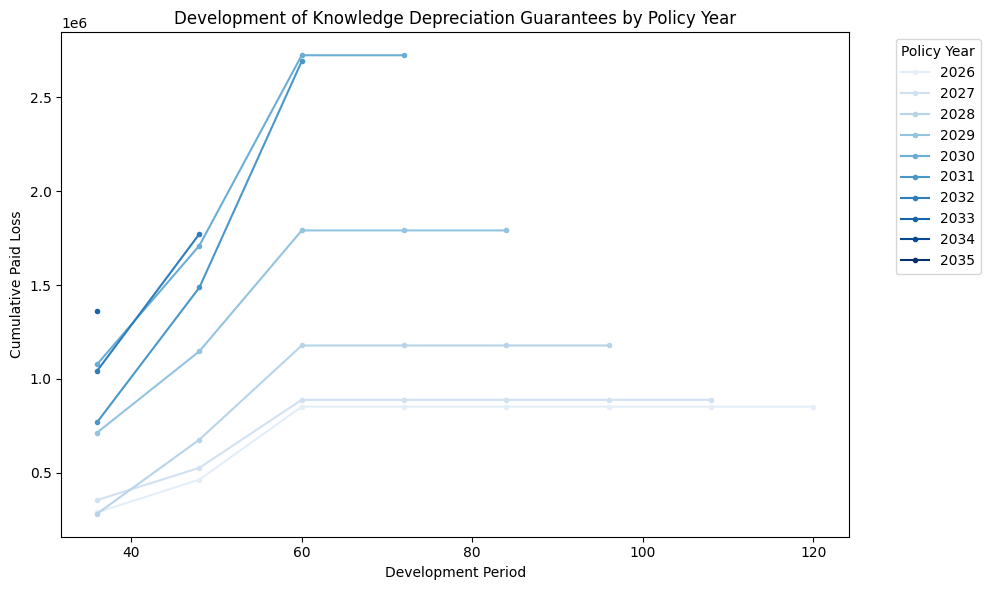

In [536]:
import numpy as np
# Generate a blue gradient color scheme
import matplotlib.cm as cm

# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
# # triangle already is the 'Cumulative Incurred' triangle:
# triangle.T.plot(
#     marker='.', grid=True, ax=ax,
#     title='Development of Knowledge Depreciation Guarantees by Policy Year',
#     xlabel='Development Period', ylabel='Cumulative Paid Loss')

years = triangle.origin
colors = cm.Blues(np.linspace(0.1, 1, len(years)))  # Blue gradient from grayish blue to neon blue

for year, color in zip(years, colors):
    triangle[triangle.origin == year].T.plot(
        ax=ax, marker='.', label=year, color=color)

plt.legend(title='Policy Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Development of Knowledge Depreciation Guarantees by Policy Year')
plt.xlabel('Development Period')
plt.ylabel('Cumulative Paid Loss')
plt.tight_layout()

In [537]:
triangle.link_ratio

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
2026,,,1.6035,1.8384,1.0000,1.0000,1.0000,1.0000,1.0000
2027,,,1.4852,1.6881,1.0000,1.0000,1.0000,1.0000,
2028,,,2.4039,1.7413,1.0000,1.0000,1.0000,,
2029,,,1.6074,1.5609,1.0000,1.0000,,,
2030,,,1.5873,1.5925,1.0000,,,,
2031,,,1.9335,1.8102,,,,,
2032,,,1.6999,,,,,,
2033,,,,,,,,,
2034,,,,,,,,,


##### Calculate the Raw Mean

In [538]:
ata_estimates = triangle.link_ratio.T.copy()
ata_estimates['Raw Mean'] = ata_estimates.mean(axis=1)
ata_estimates

,2026,2027,2028,2029,2030,2031,2032,2033,2034,Raw Mean
12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36-48,1.603465,1.485159,2.403945,1.607406,1.587315,1.933537,1.699944,NaN,NaN,1.760110
48-60,1.838426,1.688052,1.741325,1.560882,1.592475,1.810216,NaN,NaN,NaN,1.705229
60-72,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
72-84,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000
84-96,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
96-108,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
108-120,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


##### Additional Estimates of Age-to-Age Factors

In [539]:
# Last 4 Years Mean
ata_estimates.loc['36-48', 'Last 4 Years'] = np.mean([1.607406, 1.587315, 1.933537, 1.699944])
ata_estimates.loc['48-60', 'Last 4 Years'] = np.mean([1.741325, 1.560882, 1.592475, 1.810216])

# Excluding High-Low
ata_estimates.loc['36-48', 'Excl Hi-Lo'] = np.mean([1.603465, 1.607406, 1.587315, 1.933537, 1.699944])
ata_estimates.loc['48-60', 'Excl Hi-Lo'] = np.mean([1.688052, 1.741325, 1.592475, 1.810216])
ata_estimates

,2026,2027,2028,2029,2030,2031,2032,2033,2034,Raw Mean,Last 4 Years,Excl Hi-Lo
12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36-48,1.603465,1.485159,2.403945,1.607406,1.587315,1.933537,1.699944,NaN,NaN,1.760110,1.707050,1.686333
48-60,1.838426,1.688052,1.741325,1.560882,1.592475,1.810216,NaN,NaN,NaN,1.705229,1.676225,1.708017
60-72,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
72-84,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
84-96,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
96-108,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
108-120,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN


#### Make AtA Selections

In [540]:
# Excluding High-Low
ata_estimates.loc['36-48', 'Selected'] = 1.70
ata_estimates.loc['48-60', 'Selected'] = 1.69
ata_estimates

,2026,2027,2028,2029,2030,2031,2032,2033,2034,Raw Mean,Last 4 Years,Excl Hi-Lo,Selected
12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36-48,1.603465,1.485159,2.403945,1.607406,1.587315,1.933537,1.699944,NaN,NaN,1.760110,1.707050,1.686333,1.70
48-60,1.838426,1.688052,1.741325,1.560882,1.592475,1.810216,NaN,NaN,NaN,1.705229,1.676225,1.708017,1.69
60-72,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
72-84,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
84-96,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
96-108,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
108-120,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


#### Age-to-Ultimate Factors

In [541]:
tail_factor = 1.0

patterns = {
    12: 1.0,
    24: 1.0,
    36: ata_estimates.loc['36-48', 'Selected'],
    48: ata_estimates.loc['48-60', 'Selected'],
    60: tail_factor,
    72: tail_factor,
    84: tail_factor,
    96: tail_factor,
    108: tail_factor
}

print(patterns)

{12: 1.0, 24: 1.0, 36: np.float64(1.7), 48: np.float64(1.69), 60: 1.0, 72: 1.0, 84: 1.0, 96: 1.0, 108: 1.0}


In [542]:
development = cl.DevelopmentConstant(patterns=patterns, style='ldf').fit_transform(triangle)
development.cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult
(All),2.8730,2.8730,2.8730,1.6900,1.0000,1.0000,1.0000,1.0000,1.0000


In [547]:
development_model = cl.Chainladder().fit(development)
ultimates = development_model.ultimate_
ultimates

,2261
2026,"852,153"
2027,"888,378"
2028,"1,177,879"
2029,"1,790,673"
2030,"2,723,736"
2031,"2,691,827"
2032,"2,995,149"
2033,"3,905,127"
2034,
2035,


#### Develop Recent Years to Ultimate

In [582]:
ultimates_df = ultimates.to_frame()
ultimates_df['Exposure'] = 0.0

for policy_year_date in ultimates_df.index:
    # policy_year_date = pd.Timestamp(f'{policy_year}-01-01')
    policy_year = policy_year_date.year
    py_exposure = dev_triangle_available_df[(dev_triangle_available_df['Policy Year'] == policy_year)]['Exposure'].mean()
    ultimates_df.loc[policy_year_date, 'Exposure'] = py_exposure

ultimates_df.rename(columns={'2261': 'Ultimate Incurred'}, inplace=True)
ultimates_df

,Ultimate Incurred,Exposure
2026-01-01,8.521527e+05,1.024770e+07
2027-01-01,8.883785e+05,1.025357e+07
2028-01-01,1.177879e+06,1.077592e+07
2029-01-01,1.790673e+06,1.508876e+07
2030-01-01,2.723736e+06,2.421894e+07
2031-01-01,2.691827e+06,2.589143e+07
2032-01-01,2.995149e+06,2.894575e+07
2033-01-01,3.905127e+06,3.428597e+07
2034-01-01,NaN,3.528568e+07
2035-01-01,NaN,3.617208e+07


### Analyze Trend

In [583]:
# ultimates_df['Loss Ratio Per 100']
ultimates_df['Loss Rate Per 100'] = ultimates_df['Ultimate Incurred'] / ultimates_df['Exposure'] * 100.0
ultimates_df

,Ultimate Incurred,Exposure,Loss Rate Per 100
2026-01-01,8.521527e+05,1.024770e+07,8.315552
2027-01-01,8.883785e+05,1.025357e+07,8.664093
2028-01-01,1.177879e+06,1.077592e+07,10.930661
2029-01-01,1.790673e+06,1.508876e+07,11.867592
2030-01-01,2.723736e+06,2.421894e+07,11.246303
2031-01-01,2.691827e+06,2.589143e+07,10.396594
2032-01-01,2.995149e+06,2.894575e+07,10.347457
2033-01-01,3.905127e+06,3.428597e+07,11.389869
2034-01-01,NaN,3.528568e+07,NaN
2035-01-01,NaN,3.617208e+07,NaN


In [584]:
import statsmodels.api as sm
import numpy as np

# 1) prepare data
df = ultimates_df.copy()
df['Year'] = df.index.year
df['Trend'] = df['Year'] - df['Year'].min()   # 0,1,2,...
mask = df['Loss Rate Per 100'].notna()
df = df.loc[mask]

# 2) set up design matrix & response
X = sm.add_constant(df['Trend'])
y = df['Loss Rate Per 100']

# 3) fit GLM (Gamma family, log link)
glm_mod  = sm.GLM(y, X, 
                family=sm.families.Gamma(link=sm.families.links.log()),
                freq_weights=df['Exposure'])
glm_res  = glm_mod.fit()

# 4) inspect results
print(glm_res.summary())

# 5) convert trend coefficient to annual percent
coef       = glm_res.params['Trend']
annual_pct = (np.exp(coef) - 1) * 100
print(f"Estimated annual trend: {annual_pct:.2f}%")
selected_trend = 0.0255
print(f"Selected Trend: {selected_trend * 100:.2f}%")

                 Generalized Linear Model Regression Results                  
Dep. Variable:      Loss Rate Per 100   No. Observations:                    8
Model:                            GLM   Df Residuals:             159708036.14
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                       0.0064263
Method:                          IRLS   Log-Likelihood:            -1.9976e+08
Date:                Sat, 26 Apr 2025   Deviance:                   1.0121e+06
Time:                        14:56:26   Pearson chi2:                 1.03e+06
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2522   1.48e-05   1.52e+05      0.0

c:\Users\alexf\miniconda3\envs\myenv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


There seems to be a spurious annual trend of 2.55%, which is statistically significant, but is not inherent in our simulation.

Let's go with it since this is the best information we have from the perspective of a reserving actuary.

In [586]:
valuation_date = pd.Timestamp('2035-12-31')
ultimates_df['Trend Factor'] = (1 + selected_trend) ** ((valuation_date - ultimates_df.index).days / 365.25)
ultimates_df['Trended Ult Loss Rate Per 100'] = ultimates_df['Loss Rate Per 100'] * ultimates_df['Trend Factor']
ultimates_df

,Ultimate Incurred,Exposure,Loss Rate Per 100,Trend Factor,Trended Ult Loss Rate Per 100
2026-01-01,8.521527e+05,1.024770e+07,8.315552,1.286210,10.695543
2027-01-01,8.883785e+05,1.025357e+07,8.664093,1.254248,10.866924
2028-01-01,1.177879e+06,1.077592e+07,10.930661,1.223081,13.369088
2029-01-01,1.790673e+06,1.508876e+07,11.867592,1.192607,14.153371
2030-01-01,2.723736e+06,2.421894e+07,11.246303,1.162972,13.079130
2031-01-01,2.691827e+06,2.589143e+07,10.396594,1.134073,11.790494
2032-01-01,2.995149e+06,2.894575e+07,10.347457,1.105892,11.443170
2033-01-01,3.905127e+06,3.428597e+07,11.389869,1.078337,12.282119
2034-01-01,NaN,3.528568e+07,NaN,1.051542,NaN
2035-01-01,NaN,3.617208e+07,NaN,1.025412,NaN


In [628]:
paid_df = development_model.latest_diagonal.to_frame()
paid_df.rename(columns={'2035': 'Paid'}, inplace=True)

reserve_df = ultimates_df.merge(paid_df, 
                                left_index=True, 
                                right_index=True, 
                                how='left')

selected_trended_rate = reserve_df['Trended Ult Loss Rate Per 100'].mean()
selected_trend_2034 = reserve_df.loc[pd.Timestamp(
    '2034-01-01'), 'Trend Factor']
selected_trend_2035 = reserve_df.loc[pd.Timestamp(
    '2035-01-01'), 'Trend Factor']

loss_rate_2034 = selected_trended_rate / selected_trend_2034
loss_rate_2035 = selected_trended_rate / selected_trend_2035

print(
    f"Loss Rates: for 2034={loss_rate_2034:,.2f}, for 2035={loss_rate_2035:,.2f}")

reserve_df['Paid'].fillna(0, inplace=True)

reserve_df.loc[['2034-01-01', '2035-01-01'], 'Ultimate Incurred'] = reserve_df.loc[[
    '2034-01-01', '2035-01-01'], 'Exposure'] * [loss_rate_2034, loss_rate_2035] / 100.0

reserve_df['Reserve'] = reserve_df['Ultimate Incurred'] - reserve_df['Paid']

reserve_df

Loss Rates: for 2034=11.61, for 2035=11.91


C:\Users\alexf\AppData\Local\Temp\ipykernel_18620\1977714577.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reserve_df['Paid'].fillna(0, inplace=True)


,Ultimate Incurred,Exposure,Loss Rate Per 100,Trend Factor,Trended Ult Loss Rate Per 100,Paid,Reserve
2026-01-01,8.521527e+05,1.024770e+07,8.315552,1.286210,10.695543,8.521527e+05,0.000000e+00
2027-01-01,8.883785e+05,1.025357e+07,8.664093,1.254248,10.866924,8.883785e+05,0.000000e+00
2028-01-01,1.177879e+06,1.077592e+07,10.930661,1.223081,13.369088,1.177879e+06,0.000000e+00
2029-01-01,1.790673e+06,1.508876e+07,11.867592,1.192607,14.153371,1.790673e+06,0.000000e+00
2030-01-01,2.723736e+06,2.421894e+07,11.246303,1.162972,13.079130,2.723736e+06,0.000000e+00
2031-01-01,2.691827e+06,2.589143e+07,10.396594,1.134073,11.790494,2.691827e+06,0.000000e+00
2032-01-01,2.995149e+06,2.894575e+07,10.347457,1.105892,11.443170,1.772277e+06,1.222871e+06
2033-01-01,3.905127e+06,3.428597e+07,11.389869,1.078337,12.282119,1.359251e+06,2.545876e+06
2034-01-01,4.097199e+06,3.528568e+07,NaN,1.051542,NaN,0.000000e+00,4.097199e+06
2035-01-01,4.307152e+06,3.617208e+07,NaN,1.025412,NaN,0.000000e+00,4.307152e+06


In [636]:
print(f"Total Reserve as of {valuation_date.strftime('%m/%d/%Y')}: ${reserve_df['Reserve'].sum():,.2f}")

Total Reserve as of 12/31/2035: $12,173,098.12


### Analyze the Data Next Year, as of 12/31/2036

#### Develop Losses to Ultimates

In [638]:
valuation_date = pd.Timestamp('2036-12-31')
# Let 1 unit of value exposure = $100K
exposure_scale = 100_000
policy_year_0 = 2025

dev_triangle_dict_for_pd = []
for policy_year_idx, payout_dict in dev_triangle_payouts.items():
    policy_year = policy_year_0 + policy_year_idx
    exposure = initial_indices[policy_year_idx]
    # placeholders
    for month_end_idx in range(int(policy_years)):
        payout_year = int(month_end_idx + policy_year)
        dev_triangle_dict_for_pd.append({
            'Policy Year': policy_year,
            'Payout Year': payout_year,
            'Incurred': 0.0,
            'Exposure': exposure * exposure_scale,
            'Ratio': 0.0
        })

# turn into DataFrame
dev_triangle_df = pd.DataFrame(dev_triangle_dict_for_pd)

# now fill in actual payouts
for policy_year_idx, payout_dict in dev_triangle_payouts.items():
    policy_year = policy_year_0 + policy_year_idx
    for month_end_idx, payout in payout_dict.items():
        payout_year = int(month_end_idx / 12.0 + policy_year)
        mask = (dev_triangle_df['Policy Year']==policy_year) & (dev_triangle_df['Payout Year']==payout_year)
        dev_triangle_df.loc[mask, 'Incurred']  = payout * exposure_scale
        dev_triangle_df.loc[mask, 'Ratio']    = payout / exposure

# Narrow down to available experience (through year-end 2033)
dev_triangle_available_df = dev_triangle_df[(dev_triangle_df['Policy Year'] <= valuation_date.year) & 
                                            (dev_triangle_df['Payout Year'] <= valuation_date.year)].copy()

dev_triangle_available_df

,Policy Year,Payout Year,Incurred,Exposure,Ratio
0,2026,2026,0.000000e+00,1.024770e+07,0.000000
1,2026,2027,0.000000e+00,1.024770e+07,0.000000
2,2026,2028,2.890757e+05,1.024770e+07,0.006244
3,2026,2029,1.744472e+05,1.024770e+07,0.003768
4,2026,2030,3.886298e+05,1.024770e+07,0.008394
5,2027,2027,0.000000e+00,1.025357e+07,0.000000
6,2027,2028,0.000000e+00,1.025357e+07,0.000000
7,2027,2029,3.543557e+05,1.025357e+07,0.007654
8,2027,2030,1.719188e+05,1.025357e+07,0.003713
9,2027,2031,3.621040e+05,1.025357e+07,0.007821


In [639]:
dev_triangle_available_df.sort_values(by=['Policy Year', 'Payout Year'], inplace=True)
dev_triangle_available_df['Cumulative Incurred'] = dev_triangle_available_df.groupby('Policy Year')['Incurred'].cumsum()

In [640]:
dev_triangle_available_df

,Policy Year,Payout Year,Incurred,Exposure,Ratio,Cumulative Incurred
0,2026,2026,0.000000e+00,1.024770e+07,0.000000,0.000000e+00
1,2026,2027,0.000000e+00,1.024770e+07,0.000000,0.000000e+00
2,2026,2028,2.890757e+05,1.024770e+07,0.006244,2.890757e+05
3,2026,2029,1.744472e+05,1.024770e+07,0.003768,4.635229e+05
4,2026,2030,3.886298e+05,1.024770e+07,0.008394,8.521527e+05
5,2027,2027,0.000000e+00,1.025357e+07,0.000000,0.000000e+00
6,2027,2028,0.000000e+00,1.025357e+07,0.000000,0.000000e+00
7,2027,2029,3.543557e+05,1.025357e+07,0.007654,3.543557e+05
8,2027,2030,1.719188e+05,1.025357e+07,0.003713,5.262745e+05
9,2027,2031,3.621040e+05,1.025357e+07,0.007821,8.883785e+05


In [641]:
import chainladder as cl
import matplotlib.pyplot as plt

# Create the triangle
triangle = cl.Triangle(dev_triangle_available_df, 
                        origin='Policy Year', 
                        development='Payout Year', 
                        columns=['Incurred'],
                        cumulative=False)
triangle = triangle.incr_to_cum()

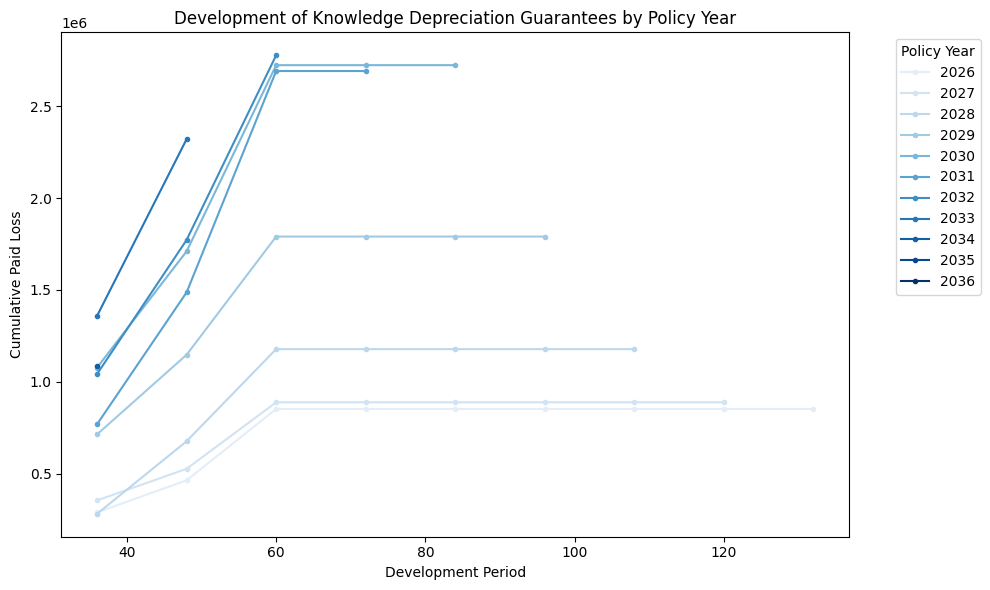

In [642]:
import numpy as np
# Generate a blue gradient color scheme
import matplotlib.cm as cm

# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
# # triangle already is the 'Cumulative Incurred' triangle:
# triangle.T.plot(
#     marker='.', grid=True, ax=ax,
#     title='Development of Knowledge Depreciation Guarantees by Policy Year',
#     xlabel='Development Period', ylabel='Cumulative Paid Loss')

years = triangle.origin
colors = cm.Blues(np.linspace(0.1, 1, len(years)))  # Blue gradient from grayish blue to neon blue

for year, color in zip(years, colors):
    triangle[triangle.origin == year].T.plot(
        ax=ax, marker='.', label=year, color=color)

plt.legend(title='Policy Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Development of Knowledge Depreciation Guarantees by Policy Year')
plt.xlabel('Development Period')
plt.ylabel('Cumulative Paid Loss')
plt.tight_layout()

In [643]:
triangle.link_ratio

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132
2026,,,1.6035,1.8384,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2027,,,1.4852,1.6881,1.0000,1.0000,1.0000,1.0000,1.0000,
2028,,,2.4039,1.7413,1.0000,1.0000,1.0000,1.0000,,
2029,,,1.6074,1.5609,1.0000,1.0000,1.0000,,,
2030,,,1.5873,1.5925,1.0000,1.0000,,,,
2031,,,1.9335,1.8102,1.0000,,,,,
2032,,,1.6999,1.5673,,,,,,
2033,,,1.7076,,,,,,,
2034,,,,,,,,,,
2035,,,,,,,,,,


##### Calculate the Raw Mean

In [644]:
ata_estimates = triangle.link_ratio.T.copy()
ata_estimates['Raw Mean'] = ata_estimates.mean(axis=1)
ata_estimates

,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,Raw Mean
12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36-48,1.603465,1.485159,2.403945,1.607406,1.587315,1.933537,1.699944,1.707634,NaN,NaN,1.753551
48-60,1.838426,1.688052,1.741325,1.560882,1.592475,1.810216,1.567266,NaN,NaN,NaN,1.685520
60-72,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
72-84,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000
84-96,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
96-108,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
108-120,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
120-132,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


##### Additional Estimates of Age-to-Age Factors

In [645]:
# Last 4 Years Mean
ata_estimates.loc['36-48', 'Last 4 Years'] = np.mean([1.587315, 1.933537, 1.699944, 1.707634])
ata_estimates.loc['48-60', 'Last 4 Years'] = np.mean([1.560882, 1.592475, 1.810216, 1.567266])

# Excluding High-Low
ata_estimates.loc['36-48', 'Excl Hi-Lo'] = np.mean([1.603465, 1.607406, 1.587315, 1.933537, 1.699944, 1.707634])
ata_estimates.loc['48-60', 'Excl Hi-Lo'] = np.mean([1.688052, 1.741325, 1.592475, 1.810216, 1.567266	])
ata_estimates

,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,Raw Mean,Last 4 Years,Excl Hi-Lo
12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36-48,1.603465,1.485159,2.403945,1.607406,1.587315,1.933537,1.699944,1.707634,NaN,NaN,1.753551,1.732108,1.689884
48-60,1.838426,1.688052,1.741325,1.560882,1.592475,1.810216,1.567266,NaN,NaN,NaN,1.685520,1.632710,1.679867
60-72,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
72-84,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
84-96,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
96-108,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
108-120,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
120-132,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN


#### Make AtA Selections

In [646]:
# Excluding High-Low
ata_estimates.loc['36-48', 'Selected'] = 1.73
ata_estimates.loc['48-60', 'Selected'] = 1.68
ata_estimates

,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,Raw Mean,Last 4 Years,Excl Hi-Lo,Selected
12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24-36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36-48,1.603465,1.485159,2.403945,1.607406,1.587315,1.933537,1.699944,1.707634,NaN,NaN,1.753551,1.732108,1.689884,1.73
48-60,1.838426,1.688052,1.741325,1.560882,1.592475,1.810216,1.567266,NaN,NaN,NaN,1.685520,1.632710,1.679867,1.68
60-72,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
72-84,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
84-96,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
96-108,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
108-120,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
120-132,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN


#### Age-to-Ultimate Factors

In [649]:
tail_factor = 1.0

patterns = {
    12: 1.0,
    24: 1.0,
    36: ata_estimates.loc['36-48', 'Selected'],
    48: ata_estimates.loc['48-60', 'Selected'],
    60: tail_factor,
    72: tail_factor,
    84: tail_factor,
    96: tail_factor,
    108: tail_factor,
    120: tail_factor
}

print(patterns)

{12: 1.0, 24: 1.0, 36: np.float64(1.73), 48: np.float64(1.68), 60: 1.0, 72: 1.0, 84: 1.0, 96: 1.0, 108: 1.0, 120: 1.0}


In [650]:
development = cl.DevelopmentConstant(patterns=patterns, style='ldf').fit_transform(triangle)
development.cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult
(All),2.9064,2.9064,2.9064,1.6800,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [651]:
development_model = cl.Chainladder().fit(development)
ultimates = development_model.ultimate_
ultimates

,2261
2026,"852,153"
2027,"888,378"
2028,"1,177,879"
2029,"1,790,673"
2030,"2,723,736"
2031,"2,691,827"
2032,"2,777,629"
2033,"3,899,453"
2034,"3,161,222"
2035,


#### Develop Recent Years to Ultimate

In [660]:
ultimates_df = ultimates.to_frame()
ultimates_df['Exposure'] = 0.0

for policy_year_date in ultimates_df.index:
    # policy_year_date = pd.Timestamp(f'{policy_year}-01-01')
    policy_year = policy_year_date.year
    py_exposure = dev_triangle_available_df[(dev_triangle_available_df['Policy Year'] == policy_year)]['Exposure'].mean()
    ultimates_df.loc[policy_year_date, 'Exposure'] = py_exposure

ultimates_df.rename(columns={'2261': 'Ultimate Incurred'}, inplace=True)
ultimates_df

,Ultimate Incurred,Exposure
2026-01-01,8.521527e+05,1.024770e+07
2027-01-01,8.883785e+05,1.025357e+07
2028-01-01,1.177879e+06,1.077592e+07
2029-01-01,1.790673e+06,1.508876e+07
2030-01-01,2.723736e+06,2.421894e+07
2031-01-01,2.691827e+06,2.589143e+07
2032-01-01,2.777629e+06,2.894575e+07
2033-01-01,3.899453e+06,3.428597e+07
2034-01-01,3.161222e+06,3.528568e+07
2035-01-01,NaN,3.617208e+07


### Analyze Trend

In [661]:
ultimates_df['Loss Rate Per 100'] = ultimates_df['Ultimate Incurred'] / ultimates_df['Exposure'] * 100.0
ultimates_df

,Ultimate Incurred,Exposure,Loss Rate Per 100
2026-01-01,8.521527e+05,1.024770e+07,8.315552
2027-01-01,8.883785e+05,1.025357e+07,8.664093
2028-01-01,1.177879e+06,1.077592e+07,10.930661
2029-01-01,1.790673e+06,1.508876e+07,11.867592
2030-01-01,2.723736e+06,2.421894e+07,11.246303
2031-01-01,2.691827e+06,2.589143e+07,10.396594
2032-01-01,2.777629e+06,2.894575e+07,9.595985
2033-01-01,3.899453e+06,3.428597e+07,11.373319
2034-01-01,3.161222e+06,3.528568e+07,8.958937
2035-01-01,NaN,3.617208e+07,NaN


In [662]:
import statsmodels.api as sm
import numpy as np

# 1) prepare data
df = ultimates_df.copy()
df['Year'] = df.index.year
df['Trend'] = df['Year'] - df['Year'].min()   # 0,1,2,...
mask = df['Loss Rate Per 100'].notna()
df = df.loc[mask]

# 2) set up design matrix & response
X = sm.add_constant(df['Trend'])
y = df['Loss Rate Per 100']

# 3) fit GLM (Gamma family, log link)
glm_mod  = sm.GLM(y, X, 
                family=sm.families.Gamma(link=sm.families.links.log()),
                freq_weights=df['Exposure'])
glm_res  = glm_mod.fit()

# 4) inspect results
print(glm_res.summary())

# 5) convert trend coefficient to annual percent
coef       = glm_res.params['Trend']
annual_pct = (np.exp(coef) - 1) * 100
print(f"Estimated annual trend: {annual_pct:.2f}%")
selected_trend = 0.0
print(f"Selected Trend: {selected_trend * 100:.2f}%")

                 Generalized Linear Model Regression Results                  
Dep. Variable:      Loss Rate Per 100   No. Observations:                    9
Model:                            GLM   Df Residuals:             194993719.12
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                        0.012098
Method:                          IRLS   Log-Likelihood:            -3.0120e+08
Date:                Sat, 26 Apr 2025   Deviance:                   2.4167e+06
Time:                        16:23:07   Pearson chi2:                 2.36e+06
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3306   1.89e-05   1.24e+05      0.0

c:\Users\alexf\miniconda3\envs\myenv\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


The trend seems to have reversed, so we select 0% for this projection.

In [663]:
ultimates_df['Trend Factor'] = (1 + selected_trend) ** ((valuation_date - ultimates_df.index).days / 365.25)
ultimates_df['Trended Ult Loss Rate Per 100'] = ultimates_df['Loss Rate Per 100'] * ultimates_df['Trend Factor']
ultimates_df

,Ultimate Incurred,Exposure,Loss Rate Per 100,Trend Factor,Trended Ult Loss Rate Per 100
2026-01-01,8.521527e+05,1.024770e+07,8.315552,1.0,8.315552
2027-01-01,8.883785e+05,1.025357e+07,8.664093,1.0,8.664093
2028-01-01,1.177879e+06,1.077592e+07,10.930661,1.0,10.930661
2029-01-01,1.790673e+06,1.508876e+07,11.867592,1.0,11.867592
2030-01-01,2.723736e+06,2.421894e+07,11.246303,1.0,11.246303
2031-01-01,2.691827e+06,2.589143e+07,10.396594,1.0,10.396594
2032-01-01,2.777629e+06,2.894575e+07,9.595985,1.0,9.595985
2033-01-01,3.899453e+06,3.428597e+07,11.373319,1.0,11.373319
2034-01-01,3.161222e+06,3.528568e+07,8.958937,1.0,8.958937
2035-01-01,NaN,3.617208e+07,NaN,1.0,NaN


In [664]:
paid_df = development_model.latest_diagonal.to_frame()
paid_df.rename(columns={f'{valudation_date.year}': 'Paid'}, inplace=True)

reserve_df = ultimates_df.merge(paid_df, 
                                left_index=True, 
                                right_index=True, 
                                how='left')

selected_trended_rate = reserve_df['Trended Ult Loss Rate Per 100'].mean()
selected_trend_2034 = reserve_df.loc[pd.Timestamp(
    '2035-01-01'), 'Trend Factor']
selected_trend_2035 = reserve_df.loc[pd.Timestamp(
    '2036-01-01'), 'Trend Factor']

loss_rate_2034 = selected_trended_rate / selected_trend_2034
loss_rate_2035 = selected_trended_rate / selected_trend_2035

print(
    f"Loss Rates: for 2034={loss_rate_2034:,.2f}, for 2035={loss_rate_2035:,.2f}")

reserve_df['Paid'].fillna(0, inplace=True)

reserve_df.loc[['2035-01-01', '2036-01-01'], 'Ultimate Incurred'] = reserve_df.loc[[
    '2035-01-01', '2036-01-01'], 'Exposure'] * [loss_rate_2034, loss_rate_2035] / 100.0

reserve_df['Reserve'] = reserve_df['Ultimate Incurred'] - reserve_df['Paid']

reserve_df

Loss Rates: for 2034=10.15, for 2035=10.15


C:\Users\alexf\AppData\Local\Temp\ipykernel_18620\453269238.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reserve_df['Paid'].fillna(0, inplace=True)


,Ultimate Incurred,Exposure,Loss Rate Per 100,Trend Factor,Trended Ult Loss Rate Per 100,Paid,Reserve
2026-01-01,8.521527e+05,1.024770e+07,8.315552,1.0,8.315552,8.521527e+05,0.000000e+00
2027-01-01,8.883785e+05,1.025357e+07,8.664093,1.0,8.664093,8.883785e+05,0.000000e+00
2028-01-01,1.177879e+06,1.077592e+07,10.930661,1.0,10.930661,1.177879e+06,0.000000e+00
2029-01-01,1.790673e+06,1.508876e+07,11.867592,1.0,11.867592,1.790673e+06,0.000000e+00
2030-01-01,2.723736e+06,2.421894e+07,11.246303,1.0,11.246303,2.723736e+06,0.000000e+00
2031-01-01,2.691827e+06,2.589143e+07,10.396594,1.0,10.396594,2.691827e+06,0.000000e+00
2032-01-01,2.777629e+06,2.894575e+07,9.595985,1.0,9.595985,2.777629e+06,0.000000e+00
2033-01-01,3.899453e+06,3.428597e+07,11.373319,1.0,11.373319,2.321103e+06,1.578350e+06
2034-01-01,3.161222e+06,3.528568e+07,8.958937,1.0,8.958937,1.087676e+06,2.073546e+06
2035-01-01,3.671427e+06,3.617208e+07,NaN,1.0,NaN,0.000000e+00,3.671427e+06


In [665]:
print(f"Total Reserve as of {valuation_date.strftime('%m/%d/%Y')}: ${reserve_df['Reserve'].sum():,.2f}")

Total Reserve as of 12/31/2036: $11,098,178.41


## Model Enhancements
- Right now we'r looking at the biggest drop only for payouts, but payment flows may happen earlier if there is an early drop followed by a bigger drop later.
  - We can improve the timing of payments to closer match actual payouts, which will effectively shift payouts from the fifth year to the fourth year